<font style='font-family: "Times New Roman", Times, serif;,color:#000099;font-weight:900;font-size:24px;text-decoration:underline;'>Curiosity project - Part A</font>

Amir Wolfenzon - 300339785, Or Sharir - 201314796, Adam Bartash - 206321440, Yishay Shapira - 203016217

1. Imports
2. Read the data
3. Functions
4. Pre processing
5. Pre evaluation
6. Evaluation
7. Data visualization

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Imports</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.stats
import seaborn as sns
import math
from scipy.spatial import distance

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Read the data</font>

In [2]:
path = r"understat_per_game.csv"
data = pd.read_csv(path)
data = data.sample(frac=1).reset_index(drop=True)

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Functions:</font>

In [3]:
# function to encode categorical column to numerical values
from sklearn import preprocessing
def cat_to_num(column_):
    le = preprocessing.LabelEncoder()
    le.fit(column_)
    return le.transform(column_)

In [4]:
# function to convert continuous column to bins 
def column_to_bins(column_, num_of_bins = 10.0):
    num_of_bins = float(num_of_bins-1)
    start = column_.min()
    stop =  column_.max()
    diff = (stop-start)
    res = (num_of_bins-num_of_bins*(stop-column_)/(diff)).astype('int')
    return res

In [5]:
# get likelihood
def get_likelihood(t_, y_):
    return scipy.stats.norm(t_, 0.5).pdf(y_)
    # we can change the function and use the likelihood option

In [6]:
# get gamma - gamma is the discount factor when we update the environment around the data point
def get_gamma(n2_, n3_, p2_, p3_):
    data_point = [n2_, n3_]
    feature = [p2_, p3_]
    # euclidean distance of two points
    dist = distance.euclidean(data_point, feature)
    # gamma = 2^-dist
    gamma = 2**(-dist)
    return gamma

In [7]:
# update theta probabilities of the data point and of the environment around the data point using gamma
# when it's the data poibt itself, gamma = 1
def update_priors(theta_ ,n1_, n2_, n3_, y_, gamma_):
    sum_p = 0
    for t in range(3):
                       
        #p = theta[x]
        p = get_likelihood(t, y_) * gamma_
        #p = likelihood[n1, n2, n3, t]
        
        # theta[t|x] ~ theta[t] * theta[x]
        theta_[n1_, n2_, n3_, t] *= p
     
        # this is for the normalization
        sum_p += theta_[n1_, n2_, n3_, t]
        
    # normalization
    for t in range(3):
        theta_[n1_, n2_, n3_, t] /= sum_p       

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Pre processing</font>

In [8]:
# createing the bins columns
data['xG_bins'] = column_to_bins(data['xG'])
data['xGA_bins'] = column_to_bins(data['xGA'])
data['league num'] = cat_to_num(data['league'])

In [9]:
# create single target column: 
# lose=0, draw=1, win=2 
data['Target'] =np.where(data['loses']==1,0,
                np.where(data['draws']==1,1,
                np.where(data['wins']==1,2,3
                ))) 

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Pre evaluation</font>

In [10]:
# split the data to train and test
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.20, random_state=55)
#train_data =train_data.head(5000)

In [11]:
# these are the indexes of matrix theta
p1_index = int(train_data['league num'].max())+2
p2_index = int(train_data['xG_bins'].max())+2
p3_index = int(train_data['xGA_bins'].max())+2

In [12]:
# 4th matrix with priors - the % of the relative part of the result in the train data
theta=np.zeros([p1_index, p2_index,p3_index, 3])
theta[:,:,:,0]=len(train_data[(train_data['Target']==0)])/len(data)
theta[:,:,:,1]=len(train_data[(train_data['Target']==1)])/len(data)
theta[:,:,:,2]=len(train_data[(train_data['Target']==2)])/len(data)

In [13]:
# Global variables for record the IG information
d_kl_arr = [] # list of IG per raw data iteration
d_kl = 0.0
d_kl_cumulative_arr = [] # list of cumulative IG per raw data iteration
d_kl_cumulative = 0.0

#record the data per result: lose, draw and win 
ig_df = pd.DataFrame(
    columns=[
        'Target',
        'IG'])

ig_df.loc[0] = [0,0.0]
ig_df.loc[1] = [1,0.0]
ig_df.loc[2] = [2,0.0]

ig_df.IG.astype('float64')

0    0.0
1    0.0
2    0.0
Name: IG, dtype: float64

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Evaluation</font>

In [14]:
for i, record in train_data.iterrows():
    row = record
    n1 = int(row['league num']) 
    n2 = int(row['xG_bins'])
    n3 = int(row['xGA_bins']) 
    y = int(row['Target'])
    
    d_kl = 0.0
    # updating the data point
    p1 = n1 
    p2 = n2
    p3 = n3
    gamma = get_gamma(n1, n2, p1, p2)
    p_before = theta[p1, p2, p3, :].flatten()
    update_priors(theta ,p1, p2, p3, y, gamma)
    p_after = theta[p1, p2, p3, :].flatten()    
    for t in range(3):
        if p_before[t] > 0.0 and p_after[t] > 0.0:
            dkl_per_res = p_after[t]* np.log2(p_after[t]/p_before[t])
            d_kl += dkl_per_res
            ig_df.loc[ig_df['Target'] == t, 'IG'] += dkl_per_res
       
    # updating the environment around the data point xG +/-1 and xGA +/-1
    # no need to update the data point around the league since there is no similarity between the leagues
    
    # update xG-1
    if n2 >0:
        p1 = n1 
        p2 = n2-1
        p3 = n3
        gamma = get_gamma(n1, n2, p1, p2)
        p_before = theta[p1, p2, p3, :].flatten()
        update_priors(theta ,p1, p2, p3, y, gamma)
        p_after = theta[p1, p2, p3, :].flatten()    
        for t in range(3):
            if p_before[t] > 0.0 and p_after[t] > 0.0:
                dkl_per_res = p_after[t]* np.log2(p_after[t]/p_before[t])
                d_kl += dkl_per_res
                ig_df.loc[ig_df['Target'] == t, 'IG'] += dkl_per_res

    # update xG+1            
    if n2 <p2_index:
        p1 = n1 
        p2 = n2+1
        p3 = n3
        gamma = get_gamma(n1, n2, p1, p2)
        p_before = theta[p1, p2, p3, :].flatten()
        update_priors(theta ,p1, p2, p3, y, gamma)
        p_after = theta[p1, p2, p3, :].flatten()    
        for t in range(3):
            if p_before[t] > 0.0 and p_after[t] > 0.0:
                dkl_per_res = p_after[t]* np.log2(p_after[t]/p_before[t])
                d_kl += dkl_per_res
                ig_df.loc[ig_df['Target'] == t, 'IG'] += dkl_per_res
    
    # update xGA-1
    if n3 >0:
        p1 = n1 
        p2 = n2
        p3 = n3-1
        gamma = get_gamma(n1, n2, p1, p2)
        p_before = theta[p1, p2, p3, :].flatten()
        update_priors(theta ,p1, p2, p3, y, gamma)
        p_after = theta[p1, p2, p3, :].flatten()    
        for t in range(3):
            if p_before[t] > 0.0 and p_after[t] > 0.0:
                dkl_per_res = p_after[t]* np.log2(p_after[t]/p_before[t])
                d_kl += dkl_per_res
                ig_df.loc[ig_df['Target'] == t, 'IG'] += dkl_per_res

    # update xGA+1
    if n3 <p3_index:
        p1 = n1 
        p2 = n2
        p3 = n3+1
        gamma = get_gamma(n1, n2, p1, p2)
        p_before = theta[p1, p2, p3, :].flatten()
        update_priors(theta ,p1, p2, p3, y, gamma)
        p_after = theta[p1, p2, p3, :].flatten()    
        for t in range(3):
            if p_before[t] > 0.0 and p_after[t] > 0.0:
                dkl_per_res = p_after[t]* np.log2(p_after[t]/p_before[t])
                d_kl += dkl_per_res
                ig_df.loc[ig_df['Target'] == t, 'IG'] += dkl_per_res
                
    d_kl_arr.append(d_kl)
    d_kl_cumulative +=d_kl
    d_kl_cumulative_arr.append(d_kl_cumulative)

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Data visualization</font>

Text(0, 0.5, 'IG')

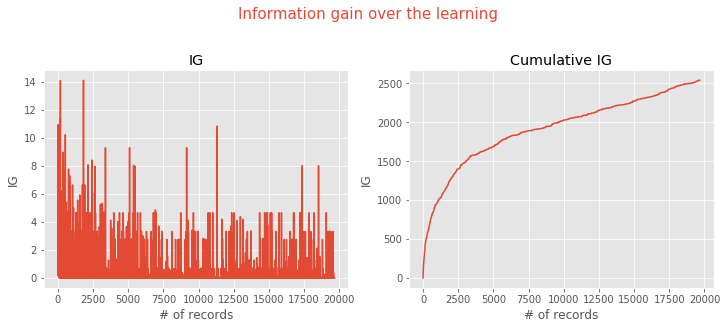

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Information gain over the learning', y=1.1 , color='C0', size='15')
axs[0].plot(d_kl_arr)
axs[0].set_title("IG")
axs[0].set_xlabel('# of records')
axs[0].set_ylabel('IG')
axs[1].plot(d_kl_cumulative_arr)
axs[1].set_title("Cumulative IG")
axs[1].set_xlabel('# of records')
axs[1].set_ylabel('IG')

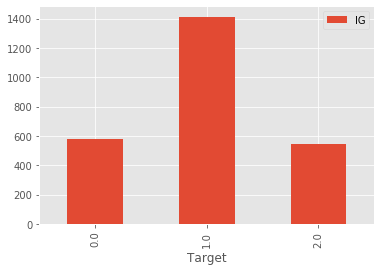

In [16]:
ig_df_sum = ig_df.groupby(['Target']).sum()
#ig_df_sum['Target'] = ['Lose','Draw','Win']
ig_df_sum.plot(kind="bar")